# Setup

In [4]:
import random
import h5py

import torch
import torch.nn as nn

from torchvision.models import *
from torchvision.transforms import *
from torch.utils.data import DataLoader, Dataset

import torch_pruning as tp

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from dataset import *
from model_loading import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Using cuda:0


# Benchmarks

## Size of Training Data

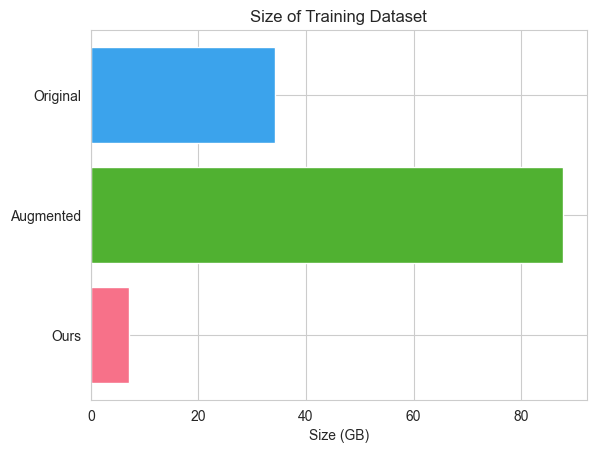

In [10]:
# Size of training data

original_data = get_dataset_size(image_size=187, channels=3, num_images=87554, data_width=32)
paper_data    = get_dataset_size(image_size=227, channels=3, num_images=152471, data_width=32)
my_data       = get_dataset_size(image_size=152, channels=3, num_images=27554, data_width=32)

compare_single_values(
    [original_data, paper_data, my_data],
    ["Original", "Augmented", "Ours"],
    axis  = "Size (GB)",
    title = "Size of Training Dataset",
)

## Model Comparison

In [ ]:
models = ["alexnet", "resnet18", "vgg16_bn", "mobilenet_v3", "mobilenet_v3_small", "ofa_595M", "ofa_pixel1_20"]
names  = ["ALX", "RSN", "VGG", "MBL", "MBS", "OFA", "OP1"]
stats  = []

dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 128,
    transform  = Resize((152, 152))
)
for i, m in enumerate(models):
    model = load_model_from_pretrained(m, f"Pretrained/{m}_ecg_ep50_i152.pth", 5)
    stat  = benchmark_model(model, dataloader["test"], names[i])
    stats.append(stat)

[ModelStats(macs=308034240, params=42322757, latency=0.010209293365478515, accuracy=97.94902038574219, name='ALX'), ModelStats(macs=877130880, params=11179077, latency=0.014706861972808839, accuracy=98.38754272460938, name='RSN'), ModelStats(macs=7126833664, params=134289477, latency=0.07538856744766236, accuracy=98.61135864257812, name='VGG'), ModelStats(macs=109647096, params=4208437, latency=0.014718267917633057, accuracy=98.140869140625, name='MBL'), ModelStats(macs=28763552, params=1522981, latency=0.007216570377349854, accuracy=97.94902038574219, name='MBS'), ModelStats(macs=259415264, params=7606613, latency=0.01892721652984619, accuracy=98.3692626953125, name='OFA'), ModelStats(macs=77714008, params=3029997, latency=0.009218394756317139, accuracy=98.02667236328125, name='OP1')]


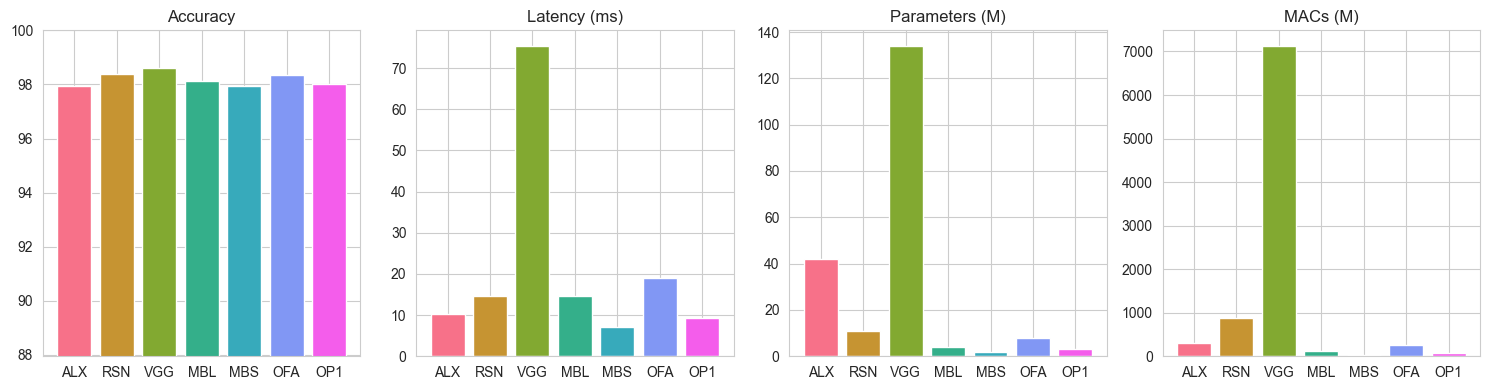

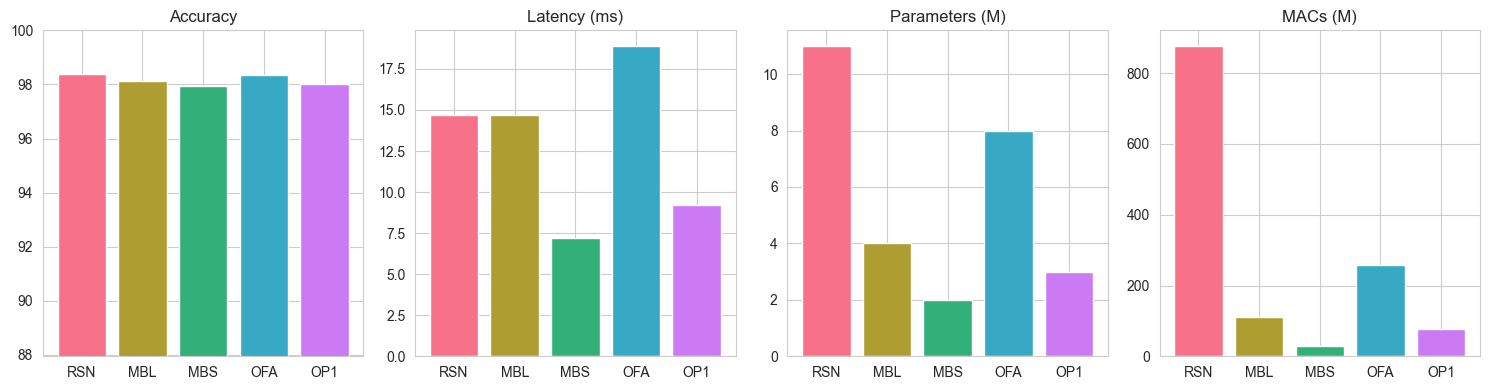

In [10]:
print(stats)

# All
compare_models(stats, fig_size=(15, 4))

# Small models
compare_models([stats[1], stats[3], stats[4], stats[5], stats[6]], fig_size=(15, 4))

## Resolution Analysis

### Best Accuracy and Latency

In [ ]:
# Resolution analysis normal metrics

resolutions = [80, 104, 128, 152, 176, 200, 224]
stats  = []
for r in resolutions:
    dataloader = build_dataloader(
        train_path = "Data/mitbih_mif_train_small.h5",
        test_path  = "Data/mitbih_mif_test.h5",
        batch_size = 128,
        transform  = Resize((r, r))
    )
    model = load_model_from_pretrained("mobilenet_v3_small", f"Pretrained/MobileNetV3-Small/mobilenet_v3_small_ecg_ep15_i{r}.pth", 5)
    stat = benchmark_model(model, dataloader["test"], str(r))
    stats.append(stat)

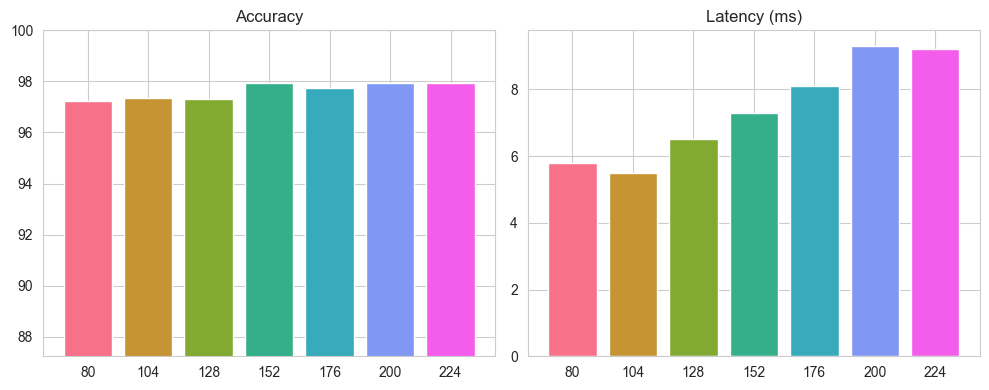

[ModelStats(macs=9165584, params=1522981, latency=0.0057552409172058104, accuracy=97.23186492919922, name='80'), ModelStats(macs=15737912, params=1522981, latency=0.0055344319343566895, accuracy=97.34606170654297, name='104'), ModelStats(macs=19386680, params=1522981, latency=0.006465885639190674, accuracy=97.31865692138672, name='128'), ModelStats(macs=28763552, params=1522981, latency=0.007266616821289063, accuracy=97.94445037841797, name='152'), ModelStats(macs=37695824, params=1522981, latency=0.008077342510223389, accuracy=97.73432922363281, name='176'), ModelStats(macs=50567288, params=1522981, latency=0.00930846929550171, accuracy=97.93074798583984, name='200'), ModelStats(macs=57192536, params=1522981, latency=0.009228127002716064, accuracy=97.92161560058594, name='224')]


In [14]:
compare_models(stats, show_macs=False, show_params=False)
print(stats)

### Running Accuracy and Loss

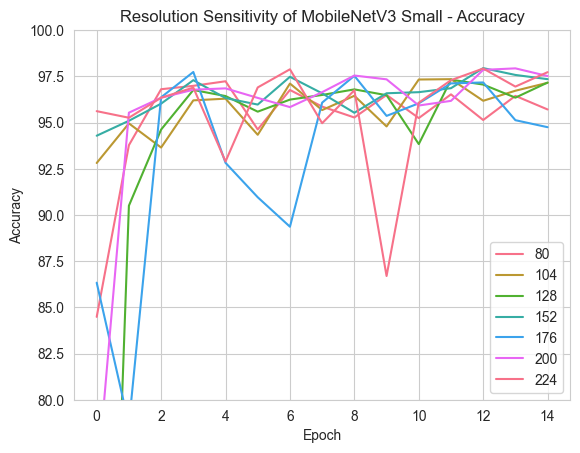

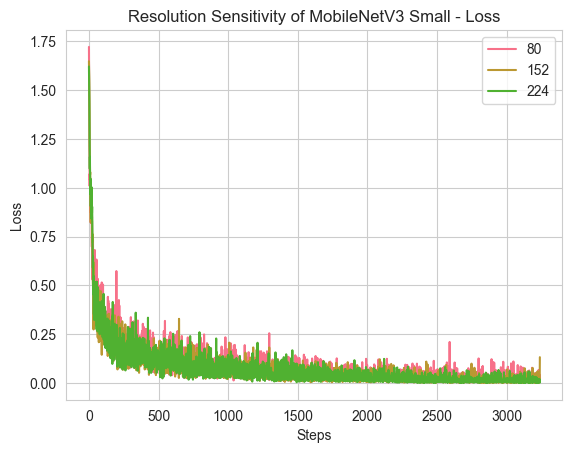

In [8]:
running_accuracy_raw = np.loadtxt("running_acc_2.txt")
running_loss_raw     = np.loadtxt("running_loss_2.txt")
running_accuracy     = dict()
running_loss         = dict()
for i, accs in enumerate(running_accuracy_raw):
    running_accuracy[str(resolutions[i])] = accs

running_loss[80]  = running_loss_raw[0]
running_loss[152] = running_loss_raw[3]
running_loss[224] = running_loss_raw[6]

compare_list_values(
    running_accuracy,
    y_axis  = "Accuracy",
    x_axis  = "Epoch",
    title   = "Resolution Sensitivity of MobileNetV3 Small - Accuracy",
    y_range = (80, 100),
)
compare_list_values(
    running_loss,
    y_axis = "Loss",
    x_axis = "Steps",
    title  = "Resolution Sensitivity of MobileNetV3 Small - Loss",
)

## VGG Pruning

### Per-layer Sparsity

In [ ]:
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 32,
    transform  = Resize((152, 152))
)

pruning_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
stats  = []

base_model = load_model_from_pretrained("vgg16_bn", "Pretrained/vgg16_bn_ecg_ep50_i152.pth", 5)
stats.append(benchmark_model(base_model, dataloader["test"], "Base"))

for pr in pruning_ratios:
    model = load_vgg_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_p{pr}.pth", pr, torch.rand((1, 3, 152, 152)))
    stat = benchmark_model(model, dataloader["test"], str(pr))
    stats.append(stat)

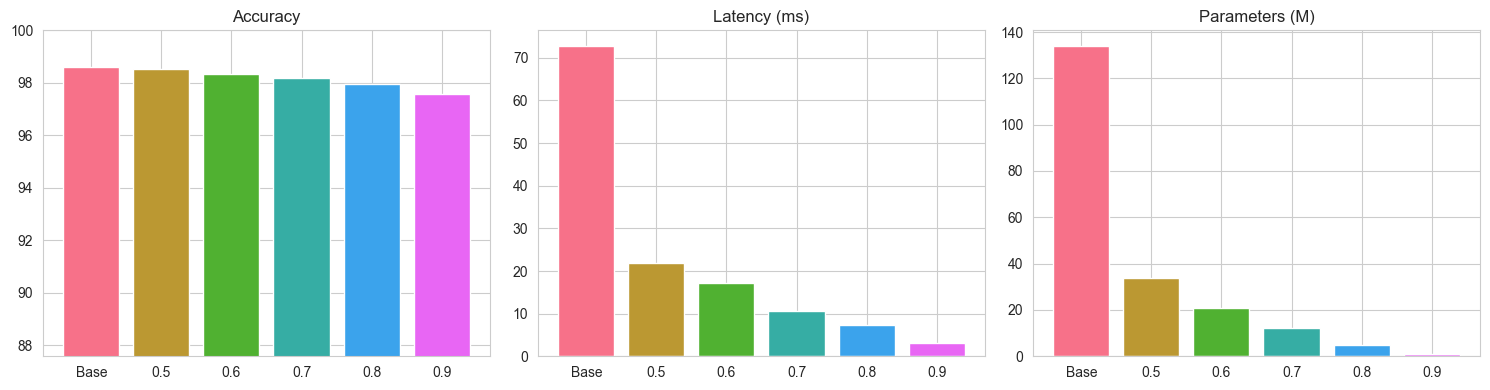

Name:     Base
Accuracy: 98.61%
Latency:  72.8 ms
Params:   134 M
MACs:     7127 M


Name:     0.5
Accuracy: 98.53%
Latency:  21.9 ms
Params:   34 M
MACs:     1793 M


Name:     0.6
Accuracy: 98.36%
Latency:  17.2 ms
Params:   21 M
MACs:     1136 M


Name:     0.7
Accuracy: 98.20%
Latency:  10.7 ms
Params:   12 M
MACs:     641 M


Name:     0.8
Accuracy: 97.94%
Latency:  7.3 ms
Params:   5 M
MACs:     283 M


Name:     0.9
Accuracy: 97.58%
Latency:  3.1 ms
Params:   1 M
MACs:     71 M




In [9]:
compare_models(stats, show_macs=False, fig_size=(15, 4))
for s in stats:
    display_model_stats(s)
    print("\n")

### Global Sparsity

In [ ]:
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 32,
    transform  = Resize((152, 152))
)

pruning_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
stats  = []

base_model = load_model_from_pretrained("vgg16_bn", "Pretrained/vgg16_bn_ecg_ep50_i152.pth", 5)
stats.append(benchmark_model(base_model, dataloader["test"], "Base"))

for pr in pruning_ratios:
    if pr == 0.9:
        max_prune = 0.95
    else:
        max_prune = 0.9

    model = torch.load(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_g{pr}.pth")

    stat = benchmark_model(model, dataloader["test"], str(pr))
    stats.append(stat)

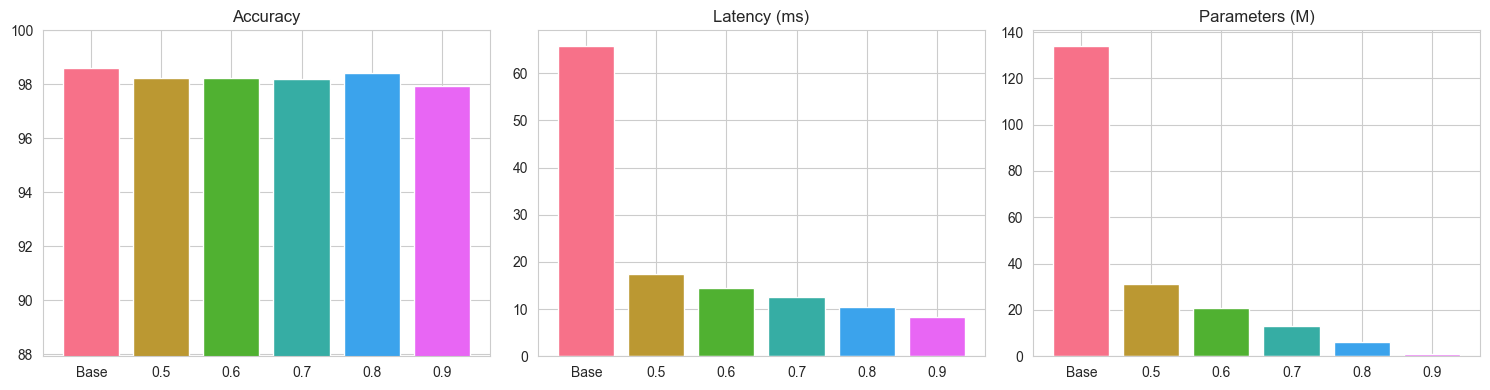

Name:     Base
Accuracy: 98.61%
Latency:  65.8 ms
Params:   134 M
MACs:     7127 M


Name:     0.5
Accuracy: 98.25%
Latency:  17.4 ms
Params:   31 M
MACs:     1112 M


Name:     0.6
Accuracy: 98.22%
Latency:  14.5 ms
Params:   21 M
MACs:     911 M


Name:     0.7
Accuracy: 98.20%
Latency:  12.5 ms
Params:   13 M
MACs:     737 M


Name:     0.8
Accuracy: 98.44%
Latency:  10.4 ms
Params:   6 M
MACs:     570 M


Name:     0.9
Accuracy: 97.93%
Latency:  8.4 ms
Params:   1 M
MACs:     411 M




In [5]:
compare_models(stats, show_macs=False, fig_size=(15, 4))
for s in stats:
    display_model_stats(s)
    print("\n")

### Per-layer vs Global

In [60]:
def plot_layer_vs_global(stats):
    names   = ["0.5", "0.6", "0.7", "0.8", "0.9"]
    accs    = [(stats[i].accuracy, stats[i+1].accuracy) for i in range(0, len(stats), 2)]
    latency = [(stats[i].latency, stats[i+1].latency) for i in range(0, len(stats), 2)]

    colors = sns.color_palette("husl", 2)

    _, ax = plt.subplots(1, 2, figsize=(15, 4))
    current_bar = 0
    for group in accs:
        ax[0].bar(current_bar, group[0], color=colors[0])
        current_bar += 1

        ax[0].bar(current_bar, group[1], color=colors[1])
        current_bar += 2

    current_bar = 0
    for group in latency:
        ax[1].bar(current_bar, round(group[0] * 1000, 1), color=colors[0])
        current_bar += 1

        ax[1].bar(current_bar, round(group[1] * 1000, 1), color=colors[1])
        current_bar += 2

    ax[0].set_ylim([97, 100])
    ax[0].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[0].set_xticklabels(names)
    ax[0].set_title("Accuracy")
    ax[0].set_xlabel("Sparsity")
    ax[0].legend(["Layer", "Global"])

    ax[1].set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax[1].set_xticklabels(names)
    ax[1].set_title("Latency (ms)")
    ax[1].set_xlabel("Sparsity")
    ax[1].legend(["Layer", "Global"])

    plt.show()

In [ ]:
dataloader = build_dataloader(
    train_path = "Data/mitbih_mif_train_small.h5",
    test_path  = "Data/mitbih_mif_test.h5",
    batch_size = 32,
    transform  = Resize((152, 152))
)

pruning_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
stats = []

for pr in pruning_ratios:
    p_model = load_vgg_from_pruned(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_p{pr}.pth", pr, torch.rand((1, 3, 152, 152)))
    p_stat = benchmark_model(p_model, dataloader["test"], f"P-{str(pr)}")
    stats.append(p_stat)

    g_model = torch.load(f"Pretrained/VGG-Pruned/vgg16_bn_ecg_ep20_i152_g{pr}.pth")
    g_stat = benchmark_model(g_model, dataloader["test"], f"G-{str(pr)}")
    stats.append(g_stat)

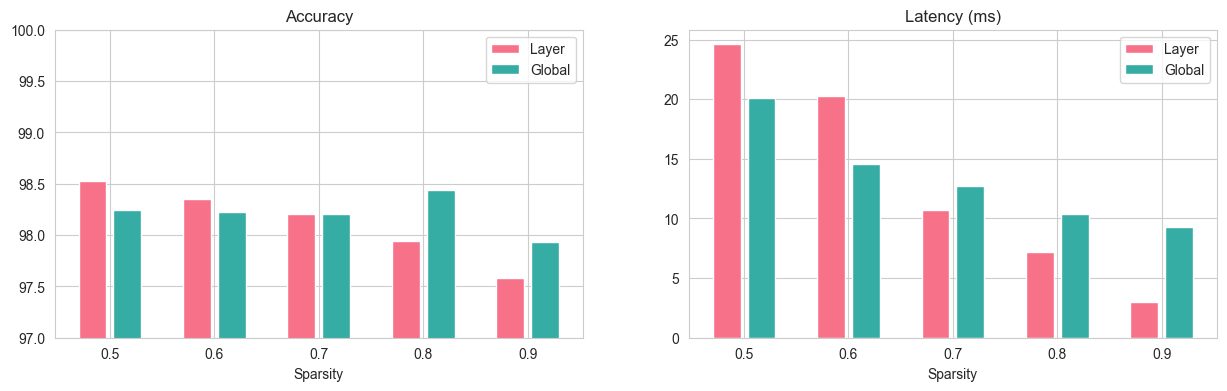

Name:     P-0.5
Accuracy: 98.53%
Latency:  24.6 ms
Params:   34 M
MACs:     1793 M


Name:     G-0.5
Accuracy: 98.25%
Latency:  20.1 ms
Params:   31 M
MACs:     1112 M


Name:     P-0.6
Accuracy: 98.36%
Latency:  20.3 ms
Params:   21 M
MACs:     1136 M


Name:     G-0.6
Accuracy: 98.22%
Latency:  14.6 ms
Params:   21 M
MACs:     911 M


Name:     P-0.7
Accuracy: 98.20%
Latency:  10.7 ms
Params:   12 M
MACs:     641 M


Name:     G-0.7
Accuracy: 98.20%
Latency:  12.7 ms
Params:   13 M
MACs:     737 M


Name:     P-0.8
Accuracy: 97.94%
Latency:  7.2 ms
Params:   5 M
MACs:     283 M


Name:     G-0.8
Accuracy: 98.44%
Latency:  10.4 ms
Params:   6 M
MACs:     570 M


Name:     P-0.9
Accuracy: 97.58%
Latency:  3.0 ms
Params:   1 M
MACs:     71 M


Name:     G-0.9
Accuracy: 97.93%
Latency:  9.3 ms
Params:   1 M
MACs:     411 M




In [61]:
plot_layer_vs_global(stats)
for s in stats:
    display_model_stats(s)
    print("\n")